In [2]:
import cortex
import seaborn as sns

In [5]:
import mne

In [6]:
import glob
import pandas as pd

In [7]:
fns = glob.glob('/data/odc/derivatives/max_wl/sub-*/ses-*/func/sub-*_ses-*_wavelengths.pkl.gz')

In [8]:
import re
import os.path as op
import numpy as np

In [9]:
derivatives = '/data/odc/derivatives/'
reg = re.compile('.*/sub-(?P<subject>.+)_ses-(?P<session>.+)_wavelengths\.pkl\.gz')

In [10]:
df = []
for fn in fns:
    print(fn)
    d = pd.read_pickle(fn)
    meta = reg.match(fn).groupdict()
    for key in meta:
        d[key] = meta[key]
            
    prf_fn = op.join(derivatives, 'prf', 'vertices', 'sub-{subject}_desc-test2_prf_optim.npz').format(**meta)
    prf_pars = np.load(prf_fn)
    
    for key in ['r2', 'size', 'angle', 'ecc']:
        d[key] = prf_pars[key]
    
    masks = cortex.utils.get_roi_verts('odc.{subject}'.format(**meta))
    
    d.loc[d.iloc[masks['V1l']].index, 'mask'] = 'V1l'
    d.loc[d.iloc[masks['V1r']].index, 'mask'] = 'V1r'
    
    d = d[~d['mask'].isnull()]
    
    df.append(d)
                                                                                                      
df = pd.concat(df)

/data/odc/derivatives/max_wl/sub-bm/ses-odc/func/sub-bm_ses-odc_wavelengths.pkl.gz
/data/odc/derivatives/max_wl/sub-de/ses-odc1/func/sub-de_ses-odc1_wavelengths.pkl.gz
/data/odc/derivatives/max_wl/sub-eo/ses-odc/func/sub-eo_ses-odc_wavelengths.pkl.gz
/data/odc/derivatives/max_wl/sub-ms/ses-odc2/func/sub-ms_ses-odc2_wavelengths.pkl.gz
/data/odc/derivatives/max_wl/sub-ns/ses-odc/func/sub-ns_ses-odc_wavelengths.pkl.gz


/Users/gdehol/miniconda3/envs/pycortex/lib/python3.7/site-packages/cortex/svgoverlay.py:465: UserWarning: Requested layer in svg file (prf_angle) contains no splines
  warnings.warn("Requested layer in svg file (%s) contains no splines"%self.name)
/Users/gdehol/miniconda3/envs/pycortex/lib/python3.7/site-packages/cortex/svgoverlay.py:465: UserWarning: Requested layer in svg file (prf_angle_1d) contains no splines
  warnings.warn("Requested layer in svg file (%s) contains no splines"%self.name)
/Users/gdehol/miniconda3/envs/pycortex/lib/python3.7/site-packages/cortex/svgoverlay.py:465: UserWarning: Requested layer in svg file (prf_ecc) contains no splines
  warnings.warn("Requested layer in svg file (%s) contains no splines"%self.name)
/Users/gdehol/miniconda3/envs/pycortex/lib/python3.7/site-packages/cortex/svgoverlay.py:465: UserWarning: Requested layer in svg file (Freesurfer V1) contains no splines
  warnings.warn("Requested layer in svg file (%s) contains no splines"%self.name)
/Us

/data/odc/derivatives/max_wl/sub-tk/ses-odc2/func/sub-tk_ses-odc2_wavelengths.pkl.gz


/Users/gdehol/miniconda3/envs/pycortex/lib/python3.7/site-packages/cortex/svgoverlay.py:465: UserWarning: Requested layer in svg file (Freesurfer V1) contains no splines
  warnings.warn("Requested layer in svg file (%s) contains no splines"%self.name)
/Users/gdehol/miniconda3/envs/pycortex/lib/python3.7/site-packages/cortex/svgoverlay.py:465: UserWarning: Requested layer in svg file (Freesurfer V2) contains no splines
  warnings.warn("Requested layer in svg file (%s) contains no splines"%self.name)


/data/odc/derivatives/max_wl/sub-tk/ses-odc3/func/sub-tk_ses-odc3_wavelengths.pkl.gz


/Users/gdehol/miniconda3/envs/pycortex/lib/python3.7/site-packages/cortex/svgoverlay.py:465: UserWarning: Requested layer in svg file (Freesurfer V1) contains no splines
  warnings.warn("Requested layer in svg file (%s) contains no splines"%self.name)
/Users/gdehol/miniconda3/envs/pycortex/lib/python3.7/site-packages/cortex/svgoverlay.py:465: UserWarning: Requested layer in svg file (Freesurfer V2) contains no splines
  warnings.warn("Requested layer in svg file (%s) contains no splines"%self.name)


/data/odc/derivatives/max_wl/sub-tr/ses-odc/func/sub-tr_ses-odc_wavelengths.pkl.gz


# Hypothesis A: Wavelenght as a function of distance to the V1/V2 border

In [11]:
df = df.set_index(['subject', 'session', 'mask'], append=True).droplevel('hemi', 0).reorder_levels(['subject', 'session', 'mask', 'vertex'], axis=0)

In [12]:
df_ = df.copy()

In [13]:
df = df[(df.r2 > 0.05) & (df['wavelength'] < 6).all(1) & (df['z-value'].abs() > 1.96).any(1) & (df.ecc < 22.)]

df = df.drop([('bm', 'odc', 'V1l'), 'ns'])

In [14]:
tmp = df[['angle', 'wavelength']].set_index('angle', append=True).stack().reset_index('angle')

In [15]:
n = 6

In [16]:
tmp['angle_bin'] = pd.cut(tmp['angle'], 
                          np.linspace(-np.pi, np.pi, n+1, endpoint=True), 
                          labels=np.linspace(-np.pi + np.pi / n, np.pi + np.pi/n, n, endpoint=False))

In [17]:
tmp['wavelength'] = tmp['wavelength'].astype(float)

In [18]:
tmp = tmp.reset_index().groupby(['subject', 'session', 'mask', 'depth', 'angle_bin', ]).mean()
tmp = tmp[~tmp.isnull().any(1)]

In [19]:
sns.set(style='white')

In [20]:
import matplotlib.pyplot as plt

In [21]:
sns.set_context('poster')

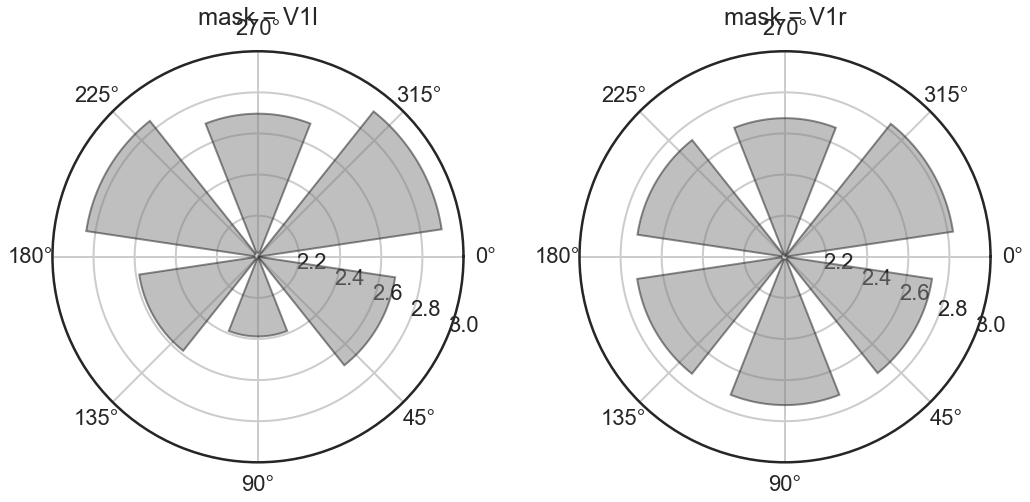

In [22]:
fac = sns.FacetGrid(tmp.reset_index().groupby(['mask', 'angle_bin'], as_index=False).mean(), 
                    col='mask',
                    height=7.5,
                    subplot_kws=dict(projection='polar', theta_direction=-1),sharex=False, sharey=False, despine=False)

fac.map(plt.bar, 'angle_bin', 'wavelength', width=.75, edgecolor='k', color='gray', alpha=.5)
fac.set_xlabels('')
fac.set_ylabels('')

fac.set(ylim=(2., 3.))

In [23]:
tmp = tmp.reset_index('angle_bin')

In [24]:
tmp['angle_degrees'] = np.round(np.rad2deg(tmp['angle_bin'].astype(float)), 0)


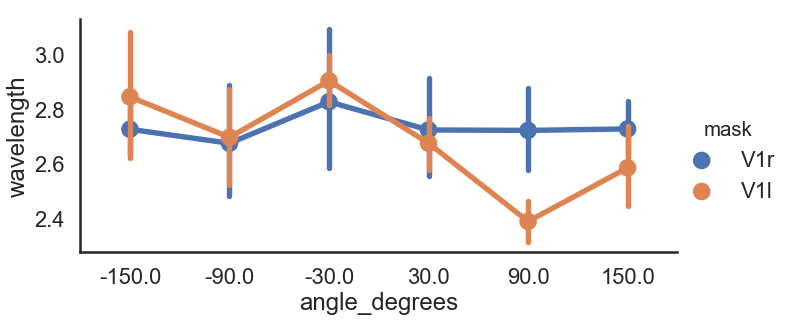

In [25]:
sns.catplot('angle_degrees', 'wavelength', 'mask', data=tmp.reset_index(), kind='point', aspect=2.)

In [26]:
tmp = tmp.reset_index()

In [27]:
tmp['subject_'] = tmp.reset_index().apply(lambda row: '{subject}.{session}'.format(**row.to_dict()), axis=1)

In [28]:
tmp = tmp.groupby(['subject_', 'mask', 'angle_bin'], as_index=False).mean()

In [29]:
tmp = tmp[~tmp.isnull().any(1)]

In [30]:
len(tmp.subject_.unique())

7

In [31]:
from statsmodels.stats.anova import AnovaRM
r = AnovaRM(tmp[tmp['mask'] == 'V1l'], 'wavelength', 'subject_', ['angle_bin']).fit()
r.summary()

,Num DF,Den DF,F Value,Pr > F
angle_bin,5.0000,25.0000,2.0930,0.0999


In [32]:
from statsmodels.stats.anova import AnovaRM
r = AnovaRM(tmp[tmp['mask'] == 'V1r'], 'wavelength', 'subject_', ['angle_bin']).fit()
r.summary()

,Num DF,Den DF,F Value,Pr > F
angle_bin,5.0000,30.0000,0.1148,0.9882


# Hypothesis B: more eccentric column s

In [33]:
tmp = df.set_index('ecc', append=True)

tmp = tmp.stack()[['z-value', 'wavelength']]

tmp = tmp[~tmp.isnull().any(1)].reset_index('ecc')

# tmp['ecc_bin'] = pd.
tmp['ecc_bin'] = pd.cut(tmp['ecc'], [0, 15, 50])
tmp['wavelength'] = tmp['wavelength'].astype(float)

tmp = tmp[tmp.ecc < 22]

In [34]:
# tmp = tmp[tmp['z-value'].abs() > 1.96]

In [35]:
tmp['right ocularity'] = (tmp['z-value'] < 0) * 100.

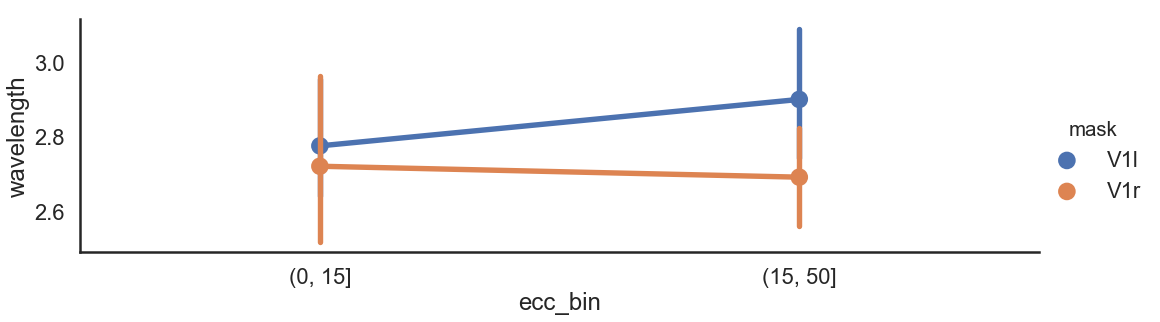

In [36]:
sns.catplot('ecc_bin', 'wavelength', 'mask', 
            data=tmp.reset_index().groupby(['subject', 'session', 'mask', 'ecc_bin'], as_index=False).mean(),
           kind='point', aspect=3.)

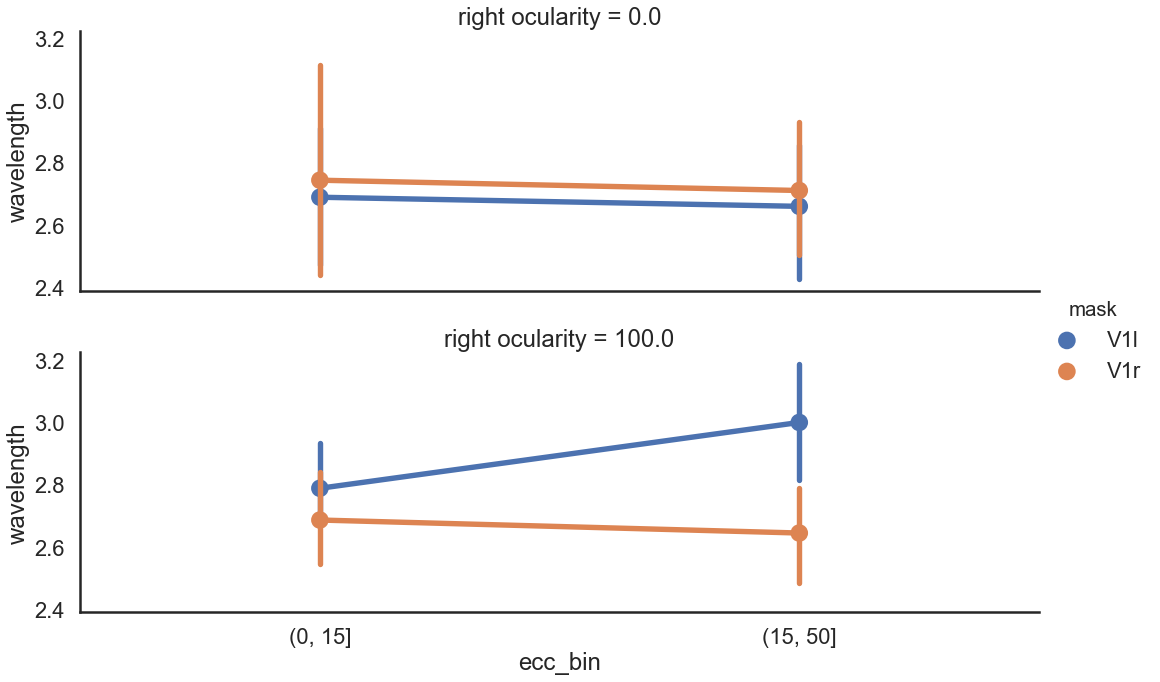

In [37]:
sns.catplot('ecc_bin', 'wavelength', 'mask', 
            row='right ocularity',
            data=tmp.reset_index().groupby(['subject', 'session', 'mask', 'right ocularity', 'ecc_bin'], as_index=False).mean(),
           kind='point', aspect=3.)

In [38]:
tmp['abs(z-value)'] = tmp['z-value'].abs()

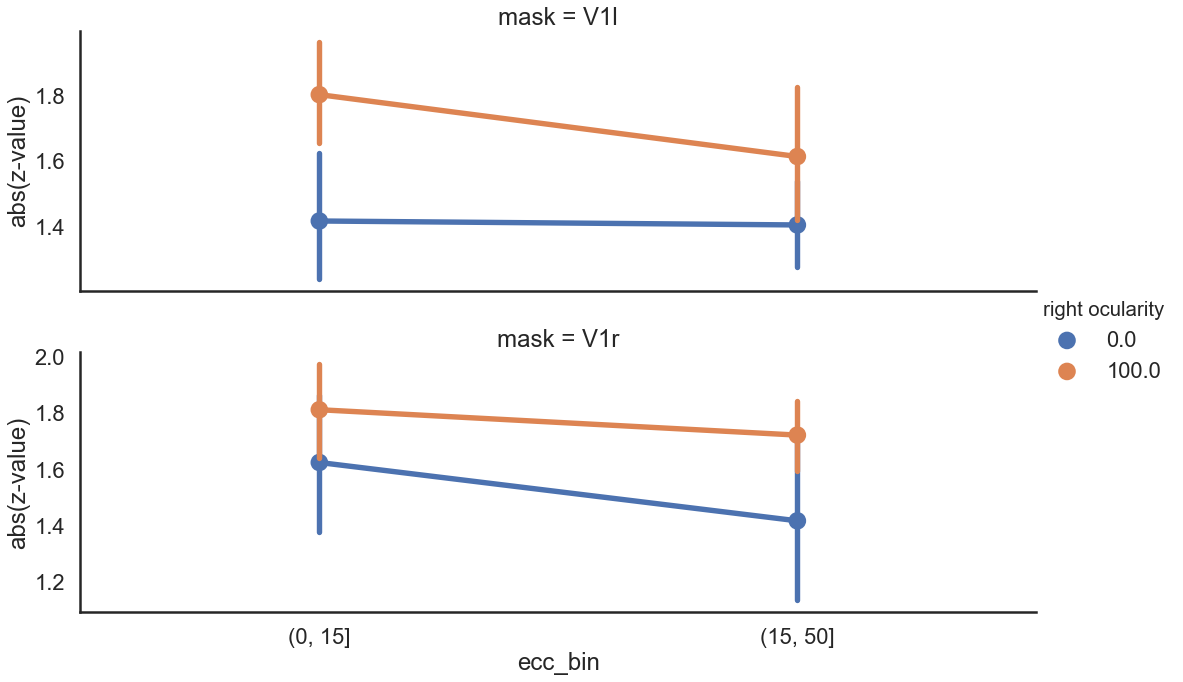

In [39]:
sns.catplot('ecc_bin', 'abs(z-value)', 'right ocularity', 
            row='mask',
            data=tmp.reset_index().groupby(['subject', 'session', 'mask', 'right ocularity', 'ecc_bin'], as_index=False).mean(),
           kind='point', aspect=3., sharey=False)

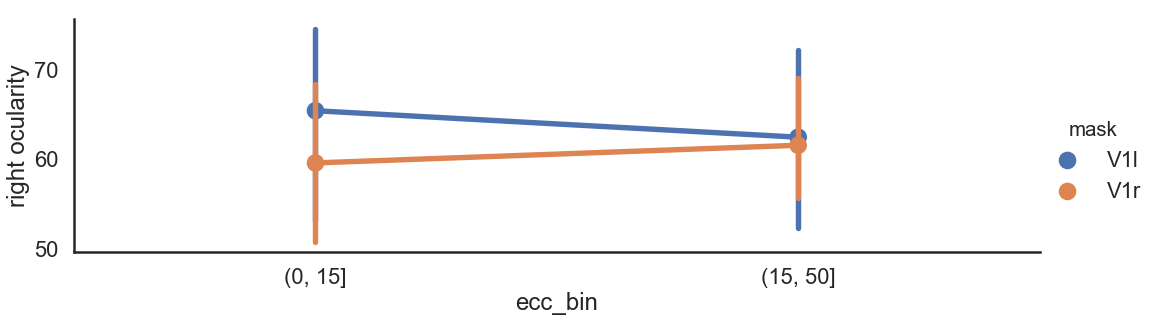

In [40]:
sns.catplot('ecc_bin', 'right ocularity', 'mask', 
            data=tmp.reset_index().groupby(['subject', 'session', 'mask', 'ecc_bin'], as_index=False).mean(),
           kind='point', aspect=3.)

In [41]:
tmp = tmp.reset_index().groupby(['subject', 'session', 'mask', 'ecc_bin'], as_index=False).mean()
tmp = tmp[~tmp.isnull().any(1)]

In [42]:
from statsmodels.stats.anova import AnovaRM
# tmp = tmp.reset_index().groupby(['subject', 'session', 'mask', 'ecc_bin'], as_index=False).mean()
tmp['subject_'] = tmp.apply(lambda row: '{subject}.{session}'.format(**row.to_dict()), axis=1)
r = AnovaRM(tmp[tmp['mask'] == 'V1l'], 'right ocularity', 'subject_', ['ecc_bin']).fit()
r.summary()

,Num DF,Den DF,F Value,Pr > F
ecc_bin,1.0000,5.0000,0.7519,0.4255


In [43]:
from statsmodels.stats.anova import AnovaRM
# tmp = tmp.reset_index().groupby(['subject', 'session', 'mask', 'ecc_bin'], as_index=False).mean()
tmp['subject_'] = tmp.apply(lambda row: '{subject}.{session}'.format(**row.to_dict()), axis=1)
r = AnovaRM(tmp[tmp['mask'] == 'V1r'], 'right ocularity', 'subject_', ['ecc_bin']).fit()
r.summary()

,Num DF,Den DF,F Value,Pr > F
ecc_bin,1.0000,6.0000,0.2866,0.6117


# Hypothesis 3: blind spot

In [1319]:
from scipy import ndimage

In [1320]:
df['x'], df['y'] = df['ecc'] * np.cos(df['angle']), df['ecc'] * np.sin(df['angle'])

In [1321]:
angle_range = (-22, 22)

In [1322]:
from scipy import interpolate

In [1323]:
tmp = df.set_index(['x', 'y'], append=True)[['z-value']].stack()
tmp = tmp.groupby(['subject', 'session', 'mask', 'vertex', 'x', 'y']).mean().reset_index(['x', 'y'])

In [1324]:
xi, yi = np.meshgrid(np.linspace(angle_range[0], angle_range[1], 1000), np.linspace(angle_range[0], angle_range[1], 1000))
pi = np.vstack((xi.ravel(), yi.ravel())).T

thetai = np.arctan2(yi, xi)
ecci = np.sqrt(xi**2 + yi**2)
    
images_l = []
images_r = []

for (subject, session, mask), d in  tmp.groupby(['subject', 'session', 'mask']):

    data = interpolate.griddata(d[['x', 'y']].values, d[['z-value']].values, pi, method='linear', fill_value=0.)
    data = data.reshape(xi.shape).astype(float)
    
    data = ndimage.gaussian_filter(data, 7./2.35)
#     data[ecci > 22.] = np.nan
    
    if mask == 'V1l':
        data[xi < 0] = np.nan
        images_l.append(data.copy())
    elif mask == 'V1r':
        data[xi > 0] = np.nan
        images_r.append(data.copy())

# images = pd.concat(images,)

In [1325]:
import mne

In [1326]:
import matplotlib.pyplot as plt

In [1327]:
from mne.stats import permutation_cluster_1samp_test

## Left

In [1328]:
t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(images_l), threshold=3.)

stat_fun(H1): min=nan max=nan
Running initial clustering
Found 49 clusters
Permuting 31 times (exact test)...


<ipython-input-1328-502213436e05>:1: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(images_l), threshold=3.)


[............................................................] 100.00%  |   
Computing cluster p-values
Done.


In [1329]:
np.sort(clusters_pv)

array([0.0625 , 0.09375, 0.125  , 0.25   , 0.53125, 0.53125, 0.59375,
       0.65625, 0.65625, 0.71875, 0.78125, 0.90625, 0.90625, 0.9375 ,
       0.96875, 0.96875, 0.96875, 0.96875, 0.96875, 1.     , 1.     ,
       1.     , 1.     , 1.     , 1.     , 1.     , 1.     , 1.     ,
       1.     , 1.     , 1.     , 1.     , 1.     , 1.     , 1.     ,
       1.     , 1.     , 1.     , 1.     , 1.     , 1.     , 1.     ,
       1.     , 1.     , 1.     , 1.     , 1.     , 1.     , 1.     ])

Nothing under p<0.05

In [1330]:
def plot_ellipse(ax, u=-15., v=-1.5, a=2.5,b=3.75, **kwargs):
    t = np.linspace(0, 2*np.pi, 100)
    x, y =  u+a*np.cos(t) , v+b*np.sin(t)
    
    rho, phi = np.hypot(x, y), np.arctan2(y, x)
    
    ax.plot(phi, rho, **kwargs)

/Users/gdehol/miniconda3/envs/pycortex/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


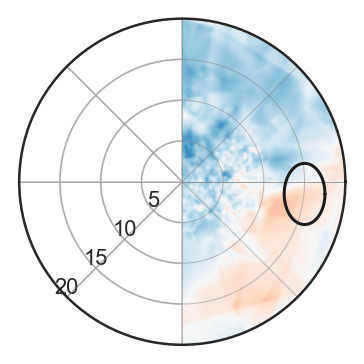

In [1331]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(projection="polar")
im = np.mean(images_l, 0)

m = plt.pcolormesh(thetai, ecci, im, cmap='RdBu_r', vmin=-3., vmax=3., rasterized=True)

ax.set_theta_direction(-1)
ax.set_ylim(0, 20.)
# plt.xticks([])
plt.yticks([5, 10, 15, 20], ha='center')
plt.xticks(plt.xticks()[0], [''] * len(plt.xticks()[0]))

for ecc in [5, 10, 15, 20]:
    ax.plot(np.linspace(0, 2*np.pi, 100, endpoint=True), [ecc]*100, c='gray', ls='-', lw=1, alpha=.5)
    
for theta in np.linspace(0, 2*np.pi, 9, endpoint=True):
    ax.plot([theta, theta], [0, 25], c='gray', ls='-', lw=1, alpha=.5)

ax.set_rlabel_position(135)


plot_ellipse(ax, u=15, v=1.5, c='k', ls='-')
plt.grid('on')
plt.savefig('/Users/gdehol/Dropbox/Science/7t_binocular/paper/figures/figure9/eye_l.pdf', dpi=300, transparent=True)

## Right

In [1332]:
t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(images_r), threshold=3., n_jobs=6)
clusters_pv

stat_fun(H1): min=nan max=nan
Running initial clustering
Found 34 clusters
Permuting 63 times (exact test)...


<ipython-input-1332-9af96f6d075d>:1: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(images_r), threshold=3., n_jobs=6)


[                                                            ]   0.00%  |   
Computing cluster p-values
Done.


array([0.96875 , 0.984375, 1.      , 1.      , 1.      , 0.96875 ,
       1.      , 1.      , 0.96875 , 1.      , 0.765625, 1.      ,
       0.21875 , 0.71875 , 1.      , 0.421875, 0.96875 , 1.      ,
       0.9375  , 1.      , 0.890625, 1.      , 0.703125, 0.9375  ,
       0.953125, 0.984375, 0.015625, 0.96875 , 0.890625, 0.953125,
       0.4375  , 0.65625 , 0.765625, 0.71875 ])

In [1333]:
np.sort(clusters_pv)

array([0.015625, 0.21875 , 0.421875, 0.4375  , 0.65625 , 0.703125,
       0.71875 , 0.71875 , 0.765625, 0.765625, 0.890625, 0.890625,
       0.9375  , 0.9375  , 0.953125, 0.953125, 0.96875 , 0.96875 ,
       0.96875 , 0.96875 , 0.96875 , 0.984375, 0.984375, 1.      ,
       1.      , 1.      , 1.      , 1.      , 1.      , 1.      ,
       1.      , 1.      , 1.      , 1.      ])

One cluster with p < 0.05

In [1334]:
from matplotlib.patches import Ellipse

/Users/gdehol/miniconda3/envs/pycortex/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/gdehol/miniconda3/envs/pycortex/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linestyle', 'lw'
  s)
/Users/gdehol/miniconda3/envs/pycortex/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


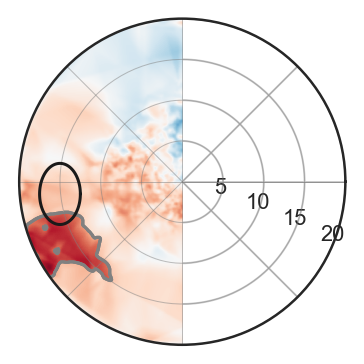

In [1335]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(projection="polar")
im = np.nanmean(images_r, 0)
plt.pcolormesh(thetai, ecci, -im, cmap='RdBu_r', vmin=-3., vmax=3., alpha=.5, rasterized=True)
im[~clusters[np.argmin(clusters_pv)]] = np.nan
m = plt.pcolormesh(thetai, ecci, -im, cmap='RdBu_r', vmin=-1.5, vmax=1.5, rasterized=True)

ax.set_theta_direction(-1)
ax.set_ylim(0, 20.)
# plt.xticks([])
plt.yticks([5, 10, 15, 20], ha='center')
plt.xticks(plt.xticks()[0], [''] * len(plt.xticks()[0]))

for ecc in [5, 10, 15, 20]:
    ax.plot(np.linspace(0, 2*np.pi, 100, endpoint=True), [ecc]*100, c='gray', ls='-', lw=1, alpha=.5)
    
for theta in np.linspace(0, 2*np.pi, 9, endpoint=True):
    ax.plot([theta, theta], [0, 25], c='gray', ls='-', lw=1, alpha=.5)

ax.contour(thetai, ecci, clusters[np.argmin(clusters_pv)], levels=1, colors=['gray'], linestyle='--', lw=.5)

plot_ellipse(ax, v=1.5, c='k', ls='-')
plt.grid('on')
plt.savefig('/Users/gdehol/Dropbox/Science/7t_binocular/paper/figures/figure9/eye_r.pdf', dpi=300, transparent=True)

In [1339]:
im.shape

(1000, 1000)

In [1349]:
max_ix = np.nanargmax(-im)

print(xi.ravel()[max_ix], yi.ravel()[max_ix])

-16.274274274274276 10.548548548548546


## Both eyes

In [1350]:
from scipy import ndimage

In [1351]:
tmp = np.vstack((np.array(images_l), -np.flip(np.array(images_r), -1)))
# tmp = np.mean(tmp, 0)
# tmp[np.isnan(tmp)] = 0
# tmp = tmp + np.flip(tmp, -1)

In [1352]:
tmp[np.isnan(tmp)] = 0
tmp = tmp + np.flip(tmp, -1)

In [1353]:
t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(tmp), threshold=3., n_jobs=6)
clusters_pv

stat_fun(H1): min=nan max=nan
Running initial clustering
Found 41 clusters
Permuting 1023 times...
[                                                            ]   0.00%  |   

/Users/gdehol/miniconda3/envs/pycortex/lib/python3.7/site-packages/mne/stats/parametric.py:65: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(X, axis=0) / np.sqrt(var / X.shape[0])
<ipython-input-1353-b2101acd57f0>:1: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(tmp), threshold=3., n_jobs=6)
/Users/gdehol/miniconda3/envs/pycortex/lib/python3.7/site-packages/mne/stats/cluster_level.py:350: RuntimeWarning: invalid value encountered in greater
  x_ins = [np.logical_and(x > thresh, include),
/Users/gdehol/miniconda3/envs/pycortex/lib/python3.7/site-packages/mne/stats/cluster_level.py:351: RuntimeWarning: invalid value encountered in less
  np.logical_and(x < -thresh, include)]



Computing cluster p-values
Done.


array([0.88476562, 0.88476562, 0.86230469, 0.86230469, 0.87109375,
       0.87109375, 0.01171875, 0.01171875, 0.56835938, 0.56835938,
       0.68457031, 0.68457031, 0.5859375 , 0.5859375 , 0.95410156,
       0.95410156, 0.0859375 , 0.0859375 , 0.60839844, 0.60839844,
       0.69726562, 0.69726562, 0.82226562, 0.82226562, 0.86425781,
       0.86425781, 0.74804688, 0.74804688, 0.9609375 , 0.9609375 ,
       0.7734375 , 0.7734375 , 0.60351562, 0.60351562, 0.88183594,
       0.88183594, 0.19433594, 0.49804688, 0.49804688, 0.95214844,
       0.95214844])

In [1354]:
np.sort(clusters_pv)

array([0.01171875, 0.01171875, 0.0859375 , 0.0859375 , 0.19433594,
       0.49804688, 0.49804688, 0.56835938, 0.56835938, 0.5859375 ,
       0.5859375 , 0.60351562, 0.60351562, 0.60839844, 0.60839844,
       0.68457031, 0.68457031, 0.69726562, 0.69726562, 0.74804688,
       0.74804688, 0.7734375 , 0.7734375 , 0.82226562, 0.82226562,
       0.86230469, 0.86230469, 0.86425781, 0.86425781, 0.87109375,
       0.87109375, 0.88183594, 0.88183594, 0.88476562, 0.88476562,
       0.95214844, 0.95214844, 0.95410156, 0.95410156, 0.9609375 ,
       0.9609375 ])

In [1355]:
np.where(clusters_pv == np.min(clusters_pv))

(array([6, 7]),)

/Users/gdehol/miniconda3/envs/pycortex/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linestyle', 'lw'
  s)


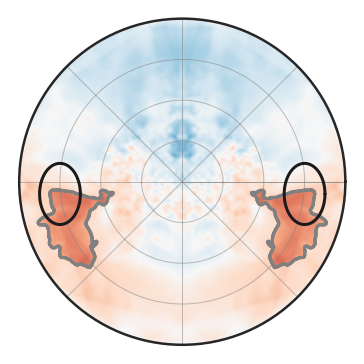

In [1356]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(projection="polar")
im = np.nanmean(tmp, 0)
plt.pcolormesh(thetai, ecci, im, cmap='RdBu_r', vmin=-3., vmax=3., alpha=.5, rasterized=True)

im[~(clusters[6] | clusters[7])] = np.nan
plt.pcolormesh(thetai, ecci, im, cmap='RdBu_r', vmin=-1.5, vmax=1.5, rasterized=True)
# plt.grid()

ax.set_theta_direction(-1)
ax.set_ylim(0, 20.)
plt.yticks([5, 10, 15, 20], [''] * 4)
plt.xticks(plt.xticks()[0], [''] * len(plt.xticks()[0]))

for ecc in [5, 10, 15, 20]:
    ax.plot(np.linspace(0, 2*np.pi, 100, endpoint=True), [ecc]*100, c='gray', ls='-', lw=1, alpha=.5)

for theta in np.linspace(0, 2*np.pi, 9, endpoint=True):
    ax.plot([theta, theta], [0, 25], c='gray', ls='-', lw=1, alpha=.5)    
    
ax.contour(thetai, ecci, (clusters[6] | clusters[7]), levels=2, colors=['gray'], linestyle='--', lw=.5)

plot_ellipse(ax, u=15., v=1.5, c='k', ls='-')
plot_ellipse(ax, u=-15., v=1.5, c='k', ls='-')
plt.savefig('/Users/gdehol/Dropbox/Science/7t_binocular/paper/figures/figure9/eye_both.pdf', dpi=300, transparent=True)

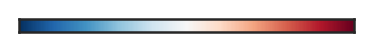

In [1357]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

plt.imshow(gradient, cmap='RdBu_r', aspect=5)
plt.xticks([])
plt.yticks([])
plt.savefig('/Users/gdehol/Dropbox/Science/7t_binocular/paper/figures/figure9/colorbar.pdf', dpi=300, transparent=True)

In [1358]:
max_ix = np.nanargmax(-im)

print(xi.ravel()[max_ix], yi.ravel()[max_ix])

-15.12912912912913 7.905905905905907


# Hypothesis 4: blind spot and cortical depth

In [1207]:
tmp = df.set_index(['x', 'y'], append=True)[['z-value']].stack()
tmp = tmp.groupby(['subject', 'session', 'mask', 'vertex', 'depth', 'x', 'y']).mean().reset_index(['x', 'y'])

In [ ]:
data

In [1229]:
xi, yi = np.meshgrid(np.linspace(angle_range[0], angle_range[1], 1000), np.linspace(angle_range[0], angle_range[1], 1000))
pi = np.vstack((xi.ravel(), yi.ravel())).T

thetai = np.arctan2(yi, xi)
ecci = np.sqrt(xi**2 + yi**2)
    
images_l = []
images_r = []

for (subject, session, mask, depth), d in  tmp.groupby(['subject', 'session', 'mask', 'depth']):

    data = interpolate.griddata(d[['x', 'y']].values, d[['z-value']].values, pi, method='linear', fill_value=0.)
    data = data.reshape(xi.shape).astype(float)
    
    data = ndimage.gaussian_filter(data, 7./2.35)
    
    data = pd.concat([pd.DataFrame(data, 
                                   index=pd.Index(yi[:, 0], name='y'),
                                  columns=pd.Index(xi[0, :], name='x'))], keys=[(subject, session, mask, depth)], names=['subject', 'session', 'mask', 'depth'])
#     data[ecci > 22.] = np.nan
    
    if mask == 'V1l':
        data[xi < 0] = np.nan
        images_l.append(data.copy())
    elif mask == 'V1r':
        data[xi > 0] = np.nan
        images_r.append(data.copy())

# images = pd.concat(images,)

In [1231]:
images_l = pd.concat(images_l)

In [1271]:
s = list(images_l.groupby(['depth']))

In [1272]:
len(s)

6

In [1275]:
np.array(tmp)

array([[('de', 'odc1'),
        x                                      -22.000000  -21.955956  -21.911912  \
subject session mask depth y                                                
de      odc1    V1l  0.143 -22.000000         NaN         NaN         NaN   
                           -21.955956         NaN         NaN         NaN   
                           -21.911912         NaN         NaN         NaN   
                           -21.867868         NaN         NaN         NaN   
                           -21.823824         NaN         NaN         NaN   
                           -21.779780         NaN         NaN         NaN   
                           -21.735736         NaN         NaN         NaN   
                           -21.691692         NaN         NaN         NaN   
                           -21.647648         NaN         NaN         NaN   
                           -21.603604         NaN         NaN         NaN   
                           -21.559560       

6
stat_fun(H1): min=nan max=nan
Running initial clustering
Found 41 clusters
Permuting 31 times (exact test)...
[                                                            ]   0.00%  |   

<ipython-input-1283-ef09e3aff34c>:8: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(tmp), threshold=3., n_jobs=6)



Computing cluster p-values
Done.
0.143 [0.46875 0.5     0.84375 0.90625 0.90625 0.90625 0.9375  0.9375  0.96875
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.     ]
6
stat_fun(H1): min=nan max=nan
Running initial clustering
Found 51 clusters
Permuting 31 times (exact test)...
[                                                            ]   0.00%  |   

<ipython-input-1283-ef09e3aff34c>:8: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(tmp), threshold=3., n_jobs=6)



Computing cluster p-values
Done.
0.286 [0.125   0.3125  0.3125  0.75    0.9375  0.9375  0.9375  0.9375  0.96875
 0.96875 0.96875 1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.     ]
6
stat_fun(H1): min=nan max=nan
Running initial clustering
Found 55 clusters
Permuting 31 times (exact test)...
[                                                            ]   0.00%  |   

<ipython-input-1283-ef09e3aff34c>:8: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(tmp), threshold=3., n_jobs=6)



Computing cluster p-values
Done.
0.429 [0.15625 0.1875  0.21875 0.3125  0.53125 0.65625 0.6875  0.75    0.75
 0.875   0.90625 0.90625 0.90625 0.9375  0.9375  0.9375  0.96875 0.96875
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.     ]
6
stat_fun(H1): min=nan max=nan
Running initial clustering
Found 50 clusters
Permuting 31 times (exact test)...
[                                                            ]   0.00%  |   

<ipython-input-1283-ef09e3aff34c>:8: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(tmp), threshold=3., n_jobs=6)



Computing cluster p-values
Done.
0.571 [0.03125 0.125   0.15625 0.34375 0.375   0.71875 0.71875 0.8125  0.875
 0.875   0.875   0.875   0.90625 0.9375  0.9375  0.96875 0.96875 0.96875
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.     ]
6
stat_fun(H1): min=nan max=nan
Running initial clustering
Found 45 clusters
Permuting 31 times (exact test)...
[                                                            ]   0.00%  |   

<ipython-input-1283-ef09e3aff34c>:8: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(tmp), threshold=3., n_jobs=6)



Computing cluster p-values
Done.
0.714 [0.0625  0.125   0.125   0.125   0.25    0.34375 0.34375 0.65625 0.78125
 0.78125 0.78125 0.84375 0.84375 0.90625 0.90625 0.90625 0.90625 0.96875
 0.96875 0.96875 1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.      1.      1.     ]
6
stat_fun(H1): min=nan max=nan
Running initial clustering
Found 50 clusters
Permuting 31 times (exact test)...
[                                                            ]   0.00%  |   

<ipython-input-1283-ef09e3aff34c>:8: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(tmp), threshold=3., n_jobs=6)



Computing cluster p-values
Done.
0.857 [0.0625  0.28125 0.4375  0.59375 0.65625 0.6875  0.8125  0.8125  0.8125
 0.8125  0.90625 0.9375  0.9375  0.96875 0.96875 1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.      1.      1.      1.      1.
 1.      1.      1.      1.      1.     ]


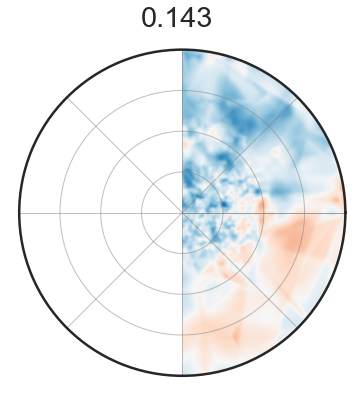

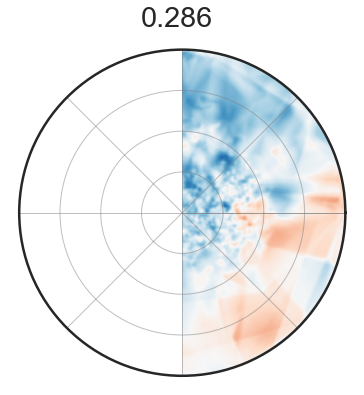

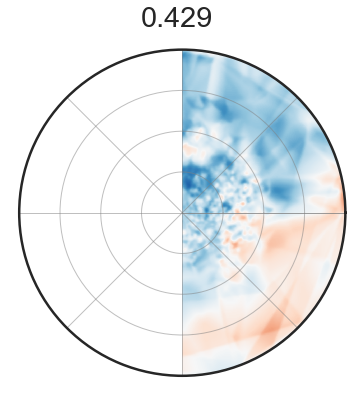

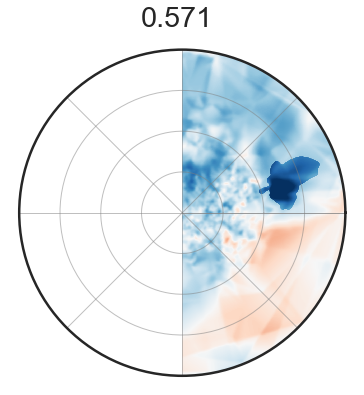

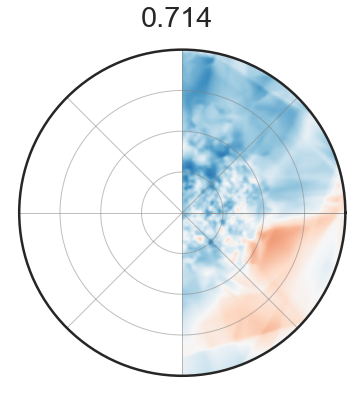

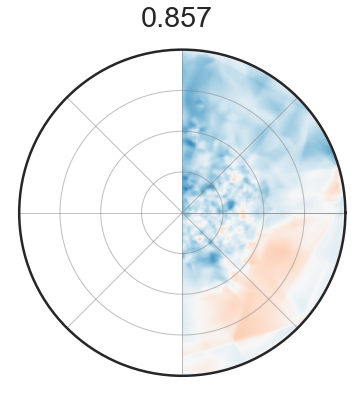

In [1283]:
# ims = images_l.groupby(['subject', 'sesion', 'depth', 'y']).mean()


for depth, d in images_l.groupby(['depth']):
      
    tmp = [e[1].values for e in list(d.groupby(['subject', 'session']))]
    print(len(tmp))
    t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(tmp), threshold=3., n_jobs=6)
    
    print(depth, np.sort(clusters_pv))
    
    im = d.groupby(['y']).mean()
    
    
    plt.figure(figsize=(6, 6))
    plt.suptitle(depth)
    ax = plt.subplot(projection="polar")
    plt.pcolormesh(thetai, ecci, im, cmap='RdBu_r', vmin=-3., vmax=3., alpha=.5, rasterized=True)    

    
    if np.min(clusters_pv) < 0.05:
        im[~clusters[np.argmin(clusters_pv)]] = np.nan
        plt.pcolormesh(thetai, ecci, im, cmap='RdBu_r', vmin=-1.5, vmax=1.5, alpha=.5, rasterized=True)


    ax.set_theta_direction(-1)
    ax.set_ylim(0, 20.)
    plt.yticks([5, 10, 15, 20], [''] * 4)
    plt.xticks(plt.xticks()[0], [''] * len(plt.xticks()[0]))

    for ecc in [5, 10, 15, 20]:
        ax.plot(np.linspace(0, 2*np.pi, 100, endpoint=True), [ecc]*100, c='gray', ls='-', lw=1, alpha=.5)

    for theta in np.linspace(0, 2*np.pi, 9, endpoint=True):
        ax.plot([theta, theta], [0, 25], c='gray', ls='-', lw=1, alpha=.5)    


7
stat_fun(H1): min=nan max=nan
Running initial clustering
Found 45 clusters
Permuting 63 times (exact test)...
[                                                            ]   0.00%  |   

<ipython-input-1284-2368af471d0a>:8: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(tmp), threshold=3., n_jobs=6)



Computing cluster p-values
Done.
0.143 [0.015625 0.421875 0.546875 0.59375  0.75     0.765625 0.828125 0.84375
 0.921875 0.96875  0.96875  0.984375 0.984375 0.984375 0.984375 0.984375
 1.       1.       1.       1.       1.       1.       1.       1.
 1.       1.       1.       1.       1.       1.       1.       1.
 1.       1.       1.       1.       1.       1.       1.       1.
 1.       1.       1.       1.       1.      ]
7
stat_fun(H1): min=nan max=nan
Running initial clustering
Found 33 clusters
Permuting 63 times (exact test)...
[                                                            ]   0.00%  |   

<ipython-input-1284-2368af471d0a>:8: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(tmp), threshold=3., n_jobs=6)



Computing cluster p-values
Done.
0.286 [0.015625 0.25     0.546875 0.75     0.75     0.875    0.875    0.890625
 0.890625 0.921875 0.9375   0.9375   0.9375   0.984375 0.984375 0.984375
 0.984375 0.984375 0.984375 1.       1.       1.       1.       1.
 1.       1.       1.       1.       1.       1.       1.       1.
 1.      ]
7
stat_fun(H1): min=nan max=nan
Running initial clustering
Found 38 clusters
Permuting 63 times (exact test)...
[                                                            ]   0.00%  |   

<ipython-input-1284-2368af471d0a>:8: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(tmp), threshold=3., n_jobs=6)



Computing cluster p-values
Done.
0.429 [0.046875 0.125    0.234375 0.421875 0.640625 0.65625  0.765625 0.796875
 0.859375 0.859375 0.96875  0.96875  0.984375 0.984375 0.984375 0.984375
 0.984375 0.984375 1.       1.       1.       1.       1.       1.
 1.       1.       1.       1.       1.       1.       1.       1.
 1.       1.       1.       1.       1.       1.      ]
7
stat_fun(H1): min=nan max=nan
Running initial clustering
Found 55 clusters
Permuting 63 times (exact test)...
[                                                            ]   0.00%  |   

<ipython-input-1284-2368af471d0a>:8: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(tmp), threshold=3., n_jobs=6)



Computing cluster p-values
Done.
0.571 [0.234375 0.34375  0.5625   0.578125 0.71875  0.71875  0.75     0.859375
 0.859375 0.875    0.890625 0.890625 0.921875 0.921875 0.9375   0.953125
 0.953125 0.953125 0.953125 0.96875  0.96875  0.96875  0.96875  0.96875
 0.96875  1.       1.       1.       1.       1.       1.       1.
 1.       1.       1.       1.       1.       1.       1.       1.
 1.       1.       1.       1.       1.       1.       1.       1.
 1.       1.       1.       1.       1.       1.       1.      ]
7
stat_fun(H1): min=nan max=nan
Running initial clustering
Found 42 clusters
Permuting 63 times (exact test)...
[                                                            ]   0.00%  |   

<ipython-input-1284-2368af471d0a>:8: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(tmp), threshold=3., n_jobs=6)



Computing cluster p-values
Done.
0.714 [0.390625 0.390625 0.671875 0.75     0.75     0.78125  0.875    0.875
 0.875    0.890625 0.90625  0.90625  0.96875  0.96875  0.96875  0.96875
 0.984375 0.984375 0.984375 0.984375 0.984375 0.984375 0.984375 0.984375
 0.984375 0.984375 0.984375 0.984375 0.984375 1.       1.       1.
 1.       1.       1.       1.       1.       1.       1.       1.
 1.       1.      ]
7
stat_fun(H1): min=nan max=nan
Running initial clustering
Found 34 clusters
Permuting 63 times (exact test)...
[                                                            ]   0.00%  |   

<ipython-input-1284-2368af471d0a>:8: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(tmp), threshold=3., n_jobs=6)



Computing cluster p-values
Done.
0.857 [0.640625 0.875    0.90625  0.984375 1.       1.       1.       1.
 1.       1.       1.       1.       1.       1.       1.       1.
 1.       1.       1.       1.       1.       1.       1.       1.
 1.       1.       1.       1.       1.       1.       1.       1.
 1.       1.      ]


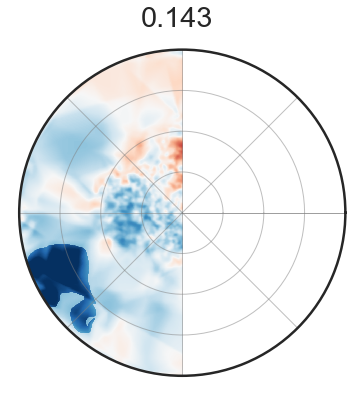

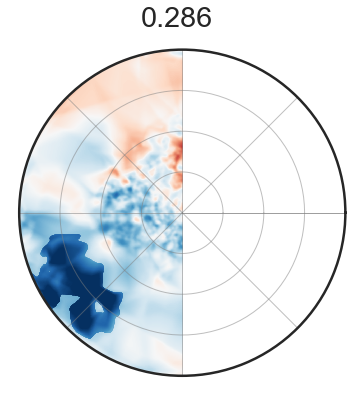

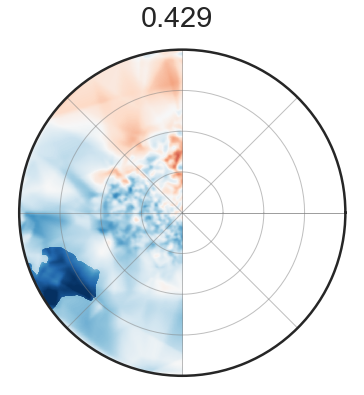

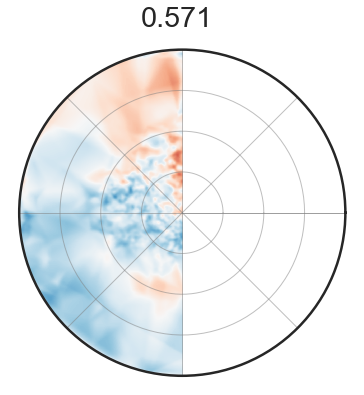

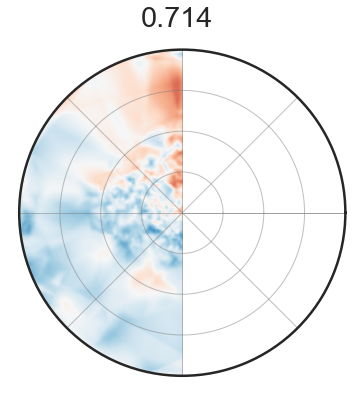

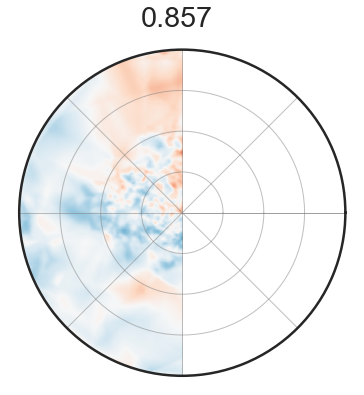

In [1284]:
# ims = images_l.groupby(['subject', 'sesion', 'depth', 'y']).mean()


for depth, d in images_r.groupby(['depth']):
      
    tmp = [e[1].values for e in list(d.groupby(['subject', 'session']))]
    print(len(tmp))
    t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(tmp), threshold=3., n_jobs=6)
    
    print(depth, np.sort(clusters_pv))
    
    im = d.groupby(['y']).mean()
    
    
    plt.figure(figsize=(6, 6))
    plt.suptitle(depth)
    ax = plt.subplot(projection="polar")
    plt.pcolormesh(thetai, ecci, im, cmap='RdBu_r', vmin=-3., vmax=3., alpha=.5, rasterized=True)    

    
    if np.min(clusters_pv) < 0.05:
        im[~clusters[np.argmin(clusters_pv)]] = np.nan
        plt.pcolormesh(thetai, ecci, im, cmap='RdBu_r', vmin=-1.5, vmax=1.5, alpha=.5, rasterized=True)


    ax.set_theta_direction(-1)
    ax.set_ylim(0, 20.)
    plt.yticks([5, 10, 15, 20], [''] * 4)
    plt.xticks(plt.xticks()[0], [''] * len(plt.xticks()[0]))

    for ecc in [5, 10, 15, 20]:
        ax.plot(np.linspace(0, 2*np.pi, 100, endpoint=True), [ecc]*100, c='gray', ls='-', lw=1, alpha=.5)

    for theta in np.linspace(0, 2*np.pi, 9, endpoint=True):
        ax.plot([theta, theta], [0, 25], c='gray', ls='-', lw=1, alpha=.5)    


In [1313]:
tmp1 = np.flip(images_l.values, -1).copy()
tmp1[np.isnan(tmp1)] = 0
tmp2 = -images_r.values.copy()
tmp2[np.isnan(tmp2)] = 0

tmp1 = pd.DataFrame(tmp1, index=images_l.index)
tmp2 = pd.DataFrame(tmp2, index=images_r.index)

images_symm = pd.concat((tmp1, tmp2))

images_symm.loc[:, 500:] = np.flip(images_symm.values[:, :500], 1)

13
stat_fun(H1): min=nan max=nan
Running initial clustering
Found 29 clusters


/Users/gdehol/miniconda3/envs/pycortex/lib/python3.7/site-packages/mne/stats/parametric.py:65: RuntimeWarning: invalid value encountered in true_divide
  return np.mean(X, axis=0) / np.sqrt(var / X.shape[0])
<ipython-input-1317-d5dc196358f5>:8: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(tmp), threshold=3., n_jobs=6)
/Users/gdehol/miniconda3/envs/pycortex/lib/python3.7/site-packages/mne/stats/cluster_level.py:350: RuntimeWarning: invalid value encountered in greater
  x_ins = [np.logical_and(x > thresh, include),
/Users/gdehol/miniconda3/envs/pycortex/lib/python3.7/site-packages/mne/stats/cluster_level.py:351: RuntimeWarning: invalid value encountered in less
  np.logical_and(x < -thresh, include)]


Permuting 1023 times...
[                                                            ]   0.00%  |   
Computing cluster p-values
Done.
0.143 [0.02636719 0.02636719 0.52539062 0.52539062 0.67089844 0.67089844
 0.68261719 0.69824219 0.69824219 0.80273438 0.80273438 0.84277344
 0.84277344 0.85449219 0.85449219 0.89257812 0.89257812 0.91699219
 0.91699219 0.96875    0.96875    0.97851562 0.97851562 0.99121094
 0.99121094 0.99511719 0.99511719 0.99804688 0.99804688]
13
stat_fun(H1): min=nan max=nan
Running initial clustering
Found 37 clusters
Permuting 1023 times...
[                                                            ]   0.00%  |   

<ipython-input-1317-d5dc196358f5>:8: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(tmp), threshold=3., n_jobs=6)



Computing cluster p-values
Done.
0.286 [0.03125    0.03125    0.1015625  0.1015625  0.24023438 0.33398438
 0.33398438 0.3671875  0.3671875  0.49902344 0.49902344 0.671875
 0.671875   0.68359375 0.68359375 0.83398438 0.83398438 0.91503906
 0.91503906 0.96191406 0.96191406 0.97265625 0.97265625 0.97851562
 0.97851562 0.98046875 0.98046875 0.98046875 0.98046875 0.984375
 0.984375   0.99023438 0.99023438 0.99121094 0.99121094 0.99316406
 0.99316406]
13
stat_fun(H1): min=nan max=nan
Running initial clustering
Found 58 clusters
Permuting 1023 times...
[                                                            ]   0.00%  |   

<ipython-input-1317-d5dc196358f5>:8: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(tmp), threshold=3., n_jobs=6)



Computing cluster p-values
Done.
0.429 [0.01855469 0.01855469 0.15722656 0.15722656 0.40332031 0.40332031
 0.58105469 0.58105469 0.58496094 0.62304688 0.62304688 0.66015625
 0.69238281 0.69238281 0.69921875 0.69921875 0.734375   0.734375
 0.75585938 0.75585938 0.75976562 0.75976562 0.76269531 0.76269531
 0.77832031 0.77832031 0.82226562 0.82226562 0.88183594 0.88183594
 0.88574219 0.88574219 0.890625   0.890625   0.94042969 0.94042969
 0.94335938 0.94335938 0.953125   0.953125   0.96386719 0.96386719
 0.96875    0.96875    0.97070312 0.97070312 0.97363281 0.97363281
 0.97363281 0.97363281 0.97949219 0.97949219 0.98632812 0.98632812
 0.98925781 0.98925781 0.98925781 0.98925781]
13
stat_fun(H1): min=nan max=nan
Running initial clustering
Found 48 clusters
Permuting 1023 times...
[                                                            ]   0.00%  |   

<ipython-input-1317-d5dc196358f5>:8: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(tmp), threshold=3., n_jobs=6)



Computing cluster p-values
Done.
0.571 [0.13476562 0.13476562 0.15039062 0.15039062 0.45019531 0.50976562
 0.52246094 0.52246094 0.59765625 0.59765625 0.66015625 0.66015625
 0.71679688 0.71679688 0.73242188 0.73242188 0.81835938 0.81835938
 0.83398438 0.83398438 0.85449219 0.85449219 0.90234375 0.90234375
 0.92871094 0.92871094 0.9375     0.9375     0.94335938 0.94335938
 0.95019531 0.95019531 0.95605469 0.95605469 0.95605469 0.95605469
 0.95703125 0.95703125 0.95996094 0.95996094 0.9609375  0.9609375
 0.96386719 0.96386719 0.96386719 0.96386719 0.98535156 0.98535156]
13
stat_fun(H1): min=nan max=nan
Running initial clustering
Found 53 clusters
Permuting 1023 times...
[                                                            ]   0.00%  |   

<ipython-input-1317-d5dc196358f5>:8: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(tmp), threshold=3., n_jobs=6)



Computing cluster p-values
Done.
0.714 [0.00585938 0.12109375 0.12109375 0.25878906 0.37988281 0.37988281
 0.39941406 0.39941406 0.43945312 0.43945312 0.62988281 0.64453125
 0.64453125 0.69726562 0.69726562 0.73925781 0.73925781 0.75292969
 0.75292969 0.78027344 0.78027344 0.83691406 0.83691406 0.83984375
 0.83984375 0.8515625  0.8515625  0.859375   0.859375   0.88769531
 0.88769531 0.91796875 0.91796875 0.9453125  0.9453125  0.95410156
 0.95410156 0.96386719 0.96386719 0.96582031 0.96582031 0.96679688
 0.96679688 0.97070312 0.97070312 0.97265625 0.97265625 0.98632812
 0.98632812 0.99121094 0.99121094 0.99121094 0.99121094]
13
stat_fun(H1): min=nan max=nan
Running initial clustering
Found 26 clusters
Permuting 1023 times...
[                                                            ]   0.00%  |   

<ipython-input-1317-d5dc196358f5>:8: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(tmp), threshold=3., n_jobs=6)



Computing cluster p-values
Done.
0.857 [0.04296875 0.34277344 0.60058594 0.71386719 0.78613281 0.88085938
 0.88085938 0.89355469 0.89355469 0.89355469 0.90917969 0.90917969
 0.92480469 0.92480469 0.97167969 0.97167969 0.97167969 0.97167969
 0.98144531 0.98144531 0.98535156 0.98535156 0.98828125 0.98828125
 0.99316406 0.99316406]


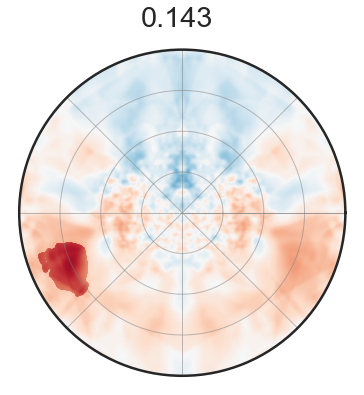

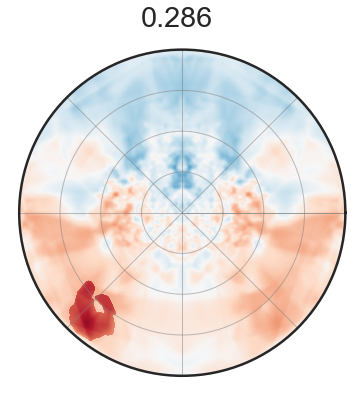

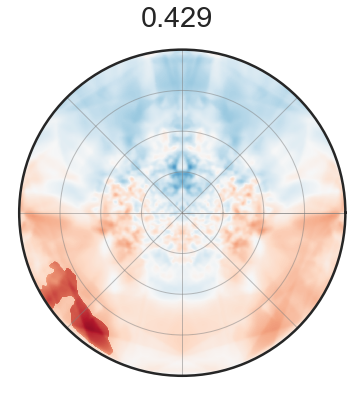

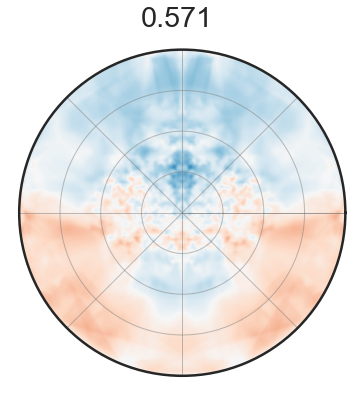

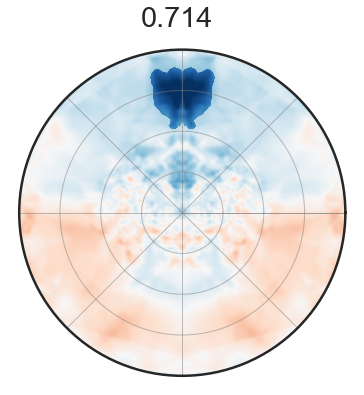

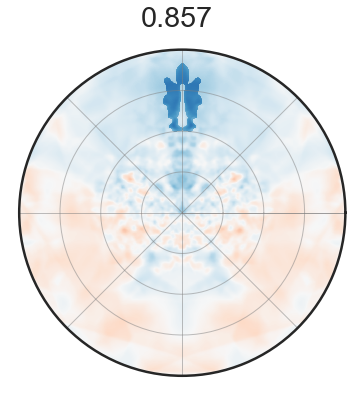

In [1317]:
# ims = images_l.groupby(['subject', 'sesion', 'depth', 'y']).mean()


for depth, d in images_symm.groupby(['depth']):
      
    tmp = [e[1].values for e in list(d.groupby(['subject', 'session', 'mask']))]
    print(len(tmp))
    t_obs, clusters, clusters_pv, H0 = permutation_cluster_1samp_test(np.array(tmp), threshold=3., n_jobs=6)
    
    print(depth, np.sort(clusters_pv))
    
    im = d.groupby(['y']).mean()
    
    
    plt.figure(figsize=(6, 6))
    plt.suptitle(depth)
    ax = plt.subplot(projection="polar")
    plt.pcolormesh(thetai, ecci, im, cmap='RdBu_r', vmin=-3., vmax=3., alpha=.5, rasterized=True)    

    
    if np.min(clusters_pv) < 0.05:
        im[~clusters[np.argmin(clusters_pv)]] = np.nan
        plt.pcolormesh(thetai, ecci, im, cmap='RdBu_r', vmin=-1.5, vmax=1.5, alpha=.5, rasterized=True)


    ax.set_theta_direction(-1)
    ax.set_ylim(0, 20.)
    plt.yticks([5, 10, 15, 20], [''] * 4)
    plt.xticks(plt.xticks()[0], [''] * len(plt.xticks()[0]))

    for ecc in [5, 10, 15, 20]:
        ax.plot(np.linspace(0, 2*np.pi, 100, endpoint=True), [ecc]*100, c='gray', ls='-', lw=1, alpha=.5)

    for theta in np.linspace(0, 2*np.pi, 9, endpoint=True):
        ax.plot([theta, theta], [0, 25], c='gray', ls='-', lw=1, alpha=.5)    
